In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import r2_score
import statsmodels.api as sm

## 1. Calculate the G4 density for each chromosome

#### Count G4s per chromosome in a BED file

In [2]:
# Function to count G4s per chromosome in a BED file
def count_features(bed_file):
    g4Data = pd.read_csv(bed_file, sep='\t', header=None, usecols=[0], names=['chrom'])
    return g4Data['chrom'].value_counts()

# List of BED files (modify paths accordingly)
bed_files = glob.glob("../datasets/pG4s/*_*/chrG*.bed")  # Assumes all BED files are in the current directory

g4Data = pd.DataFrame()
for bed_file in bed_files:
    counts = count_features(bed_file)
    g4Data[bed_file] = counts
g4Data.fillna(0, inplace=True)
g4Data.index.name = ""
g4Data.index = g4Data.index.str.replace("chr","")
g4Data.sort_values(by="", inplace=True)

# Separate numeric and non-numeric indexes ('X', 'Y')
numeric_index = g4Data.index[g4Data.index.str.isnumeric()]
non_numeric_index = g4Data.index[~g4Data.index.str.isnumeric()]
sorted_numeric_index = sorted(numeric_index, key=int)
sorted_index = sorted_numeric_index + list(non_numeric_index)
# Reindex the dataframe with the sorted index
g4Data = g4Data.reindex(sorted_index)

# change columns
g4Data.columns = ['b. orangutan','chimpanzee','s. orangutan','human','gorilla', 'bonobo']
g4Data = g4Data[["human", "bonobo", "chimpanzee", "gorilla", "s. orangutan", "b. orangutan"]]

#### Get the length of each chromosome in a species

In [3]:
chrLen = chrLen = pd.read_csv('../datasets/dataForAnalysis/genomeLength/totalGenomeLength.dat', sep='\t', header=0, index_col=0)
chrLen.columns = ["human", "bonobo", "chimpanzee", "gorilla", "s. orangutan", "b. orangutan"]
# remove last row
chrLen = chrLen[:-1]

#### Calculate the density of G4s in each chromosome and save the data

In [4]:
# density calculated as number of G4s per 1kb
data = g4Data/chrLen*1e3
data.to_csv('../datasets/dataForAnalysis/density/density.dat', sep='\t', header=True, index=True)

# reload the data after saving
data = pd.read_csv('../datasets/dataForAnalysis/density/density.dat',index_col=0,header=0, sep="\t")
data.columns = ["H. sapiens", "P. paniscus", "P. troglodytes", "G. gorilla", "P. abelii", "P. pygmaeus"]

#convert the "-" into NaN
data = data.replace('-', np.nan)
data = data.apply(pd.to_numeric)

#### Prepare the data for plotting

In [5]:
def str_to_int(s):
    try:
        return str(int(s))
    except:
        return str(s)
    
hsa_map = pd.read_csv('../datasets/dataForAnalysis/maps/align.hsa.map', sep='\t', header=0, index_col=0)

#define a dataframe with 25 rows and 6 columns
df = pd.DataFrame(np.nan, columns=["P. paniscus", "P. troglodytes", "H. sapiens", "G. gorilla", "P. pygmaeus", "P. abelii"],
                  index=["1","2a","2b","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","X","Y"])

# set index column name
df.index.name = "HSA"

species_list_non_human = ["P. paniscus", "P. troglodytes", "H. sapiens", "G. gorilla", "P. pygmaeus", "P. abelii"]
name_mapping = {"P. paniscus":"pan", "P. troglodytes": "pan", "H. sapiens": "hs1", "G. gorilla": "gor", "P. pygmaeus": "pon", "P. abelii": "pon"}

for species in species_list_non_human:
    for ind in df.index:
        keyval = str_to_int(hsa_map[ind][name_mapping[species]])
        if keyval != 'nan':
            df.loc[ind, species] = data.loc[keyval, species]
        else:
            df.loc[ind, species] = np.nan

df.loc["2a","H. sapiens"] = data.loc["2","H. sapiens"]
df.loc["2b","H. sapiens"] = data.loc["2","H. sapiens"]

#### Plot the density heatmap

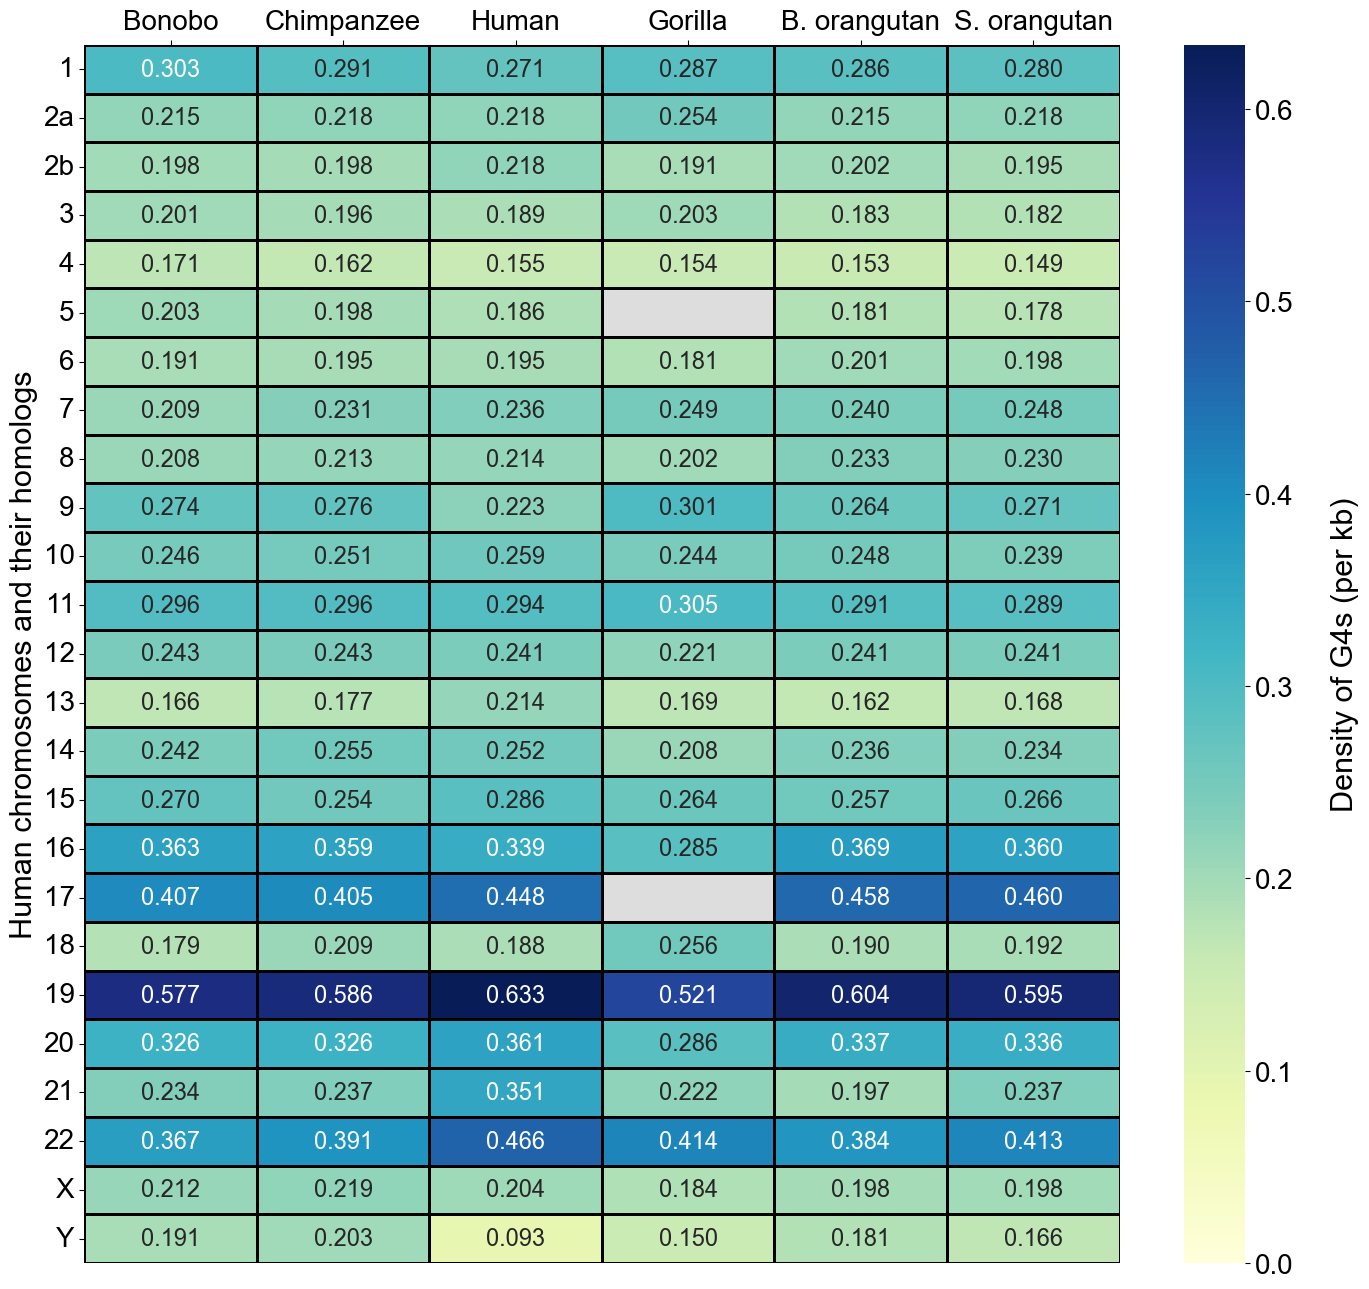

In [6]:
plt.figure(figsize=(14,13))

rcParams['font.family'] = 'Arial'
cmap = plt.get_cmap('YlGnBu')
cmap.set_bad('#ddd')

#plot a heatmap using seaborn with annotation fontsize 15 and cmap fontsize 15 and set nan values to white
ax = sns.heatmap(df, annot=True, fmt=".3f", cmap=cmap, annot_kws={'size': 17}, cbar_kws={'label': '\nDensity of G4s (per kb)'},linewidths=1, linecolor='black', vmin=0) 

colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=20)  # Adjust colorbar tick font size
colorbar.set_label('\nDensity of G4s (per kb)', fontsize=22)  # Adjust colorbar label font size

# plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.tick_params(labelsize=20)

# make font bold
plt.ylabel("Human chromosomes and their homologs",fontsize=22)
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5],["Bonobo","Chimpanzee","Human","Gorilla","B. orangutan","S. orangutan"],rotation=0, fontsize=20)
plt.gca().xaxis.set_ticks_position('top')  # Move x ticks to the top
plt.gca().xaxis.set_label_position('top')  # Move x label to the top

plt.tight_layout()

plt.savefig('../plots/densityPlots/heatmap.png',dpi=300)
plt.savefig('../plots/densityPlots/heatmap.svg', format='svg', transparent=True)

## 2. Look at the association between G4 density, gene density and GC content

#### Load the requried datasets

In [7]:
# Load the gene coverage data
gene_coverage = pd.read_csv('../datasets/dataForAnalysis/density/geneCoverage.dat', sep='\t', header=None)
gene_coverage.columns = ['chr', 'gene_coverage']
chrLenHuman = chrLen["human"].drop(["23"])
gene_density = np.array(gene_coverage['gene_coverage'])/np.array(chrLenHuman)*1e6

# Load the GC content data
GC_content = pd.read_csv('../datasets/dataForAnalysis/density/GC_content.dat', sep='\t', header=None)
GC_content.columns = ['chr', 'GC_content']
GC_content = np.array(GC_content['GC_content'])

# Load the G4 density data
g4Density = data["H. sapiens"].drop(["23"], axis=0)

#### G4 Density vs Gene Density

/var/folders/34/c98ml9js6l75mkgs9vw2bmqmcjj52k/T/ipykernel_64544/1711867172.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(gene_density[i], g4Density[i], f'  {labels[i]} ', fontsize=8, ha='left', va='center', color='grey')


                            OLS Regression Results                            
Dep. Variable:             g4_density   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     88.24
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           3.72e-09
Time:                        17:01:05   Log-Likelihood:                 37.438
No. Observations:                  24   AIC:                            -70.88
Df Residuals:                      22   BIC:                            -68.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0999      0.021      4.705   

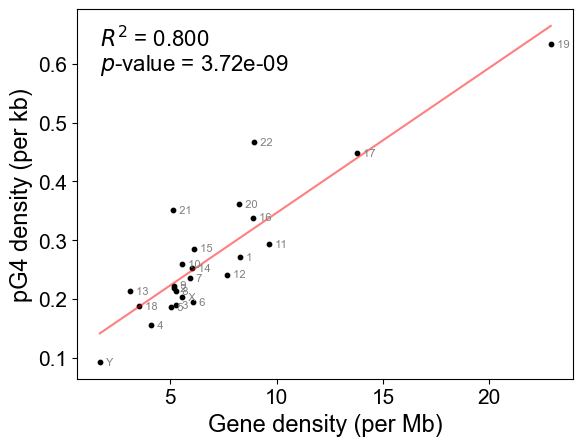

In [8]:
# plot the scatter plot
plt.scatter(gene_density,g4Density.dropna(), color='#000', s=10)

labels = list(range(1,23)) + ['X','Y']
for i in range(len(gene_density)):
    plt.text(gene_density[i], g4Density[i], f'  {labels[i]} ', fontsize=8, ha='left', va='center', color='grey')

# fitting the model
model = LinearRegression()
model.fit(gene_density.reshape(-1,1),g4Density.dropna())
y_pred = model.predict(gene_density.reshape(-1,1))
r2 = r2_score(g4Density.dropna(), y_pred)

# plotting the fit line
plt.plot([np.min(gene_density.reshape(-1,1)), np.max(gene_density.reshape(-1,1))], [np.min(y_pred), np.max(y_pred)], color='#f00', linewidth=1.5, alpha=0.5)
plt.text(1.7,0.63, r'$R^2$ = %.3f' %r2, fontsize=16)
plt.text(1.7,0.59, r'$p$-value = 3.72e-09', fontsize=16)

#draw a line for fitting
plt.xlabel("Gene density (per Mb)",fontsize=17)
plt.ylabel("pG4 density (per kb)",fontsize=17)
# plt.title("Human gene density vs G4 density (in CHR)",fontsize=17)

#decrease the ticks fontsize
plt.tick_params(labelsize=15)

plt.savefig('../plots/densityPlots/density_reg.png',dpi=300,bbox_inches='tight')
plt.savefig('../plots/densityPlots/density_reg.svg', format='svg', transparent=True)

# Load the data
genedenvsg4den = pd.DataFrame({'gene_density': gene_density, 'g4_density': g4Density})

# Define the independent variables (constant, GCcontent, and GCcontent_squared)
X = sm.add_constant(genedenvsg4den[["gene_density"]])
# X = genedenvsg4den[["GCcontent", "GCcontent_squared"]]

# Fit the quadratic model
model = sm.OLS(genedenvsg4den["g4_density"], X).fit()
print(model.summary())

plt.show()

#### G4 Density vs GC content

/var/folders/34/c98ml9js6l75mkgs9vw2bmqmcjj52k/T/ipykernel_64544/930514692.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(GC_content[i], g4Density[i], f'  {labels[i]} ', fontsize=8, ha='left', va='center', color='grey')


                            OLS Regression Results                            
Dep. Variable:             g4_density   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     231.6
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           3.67e-13
Time:                        17:01:05   Log-Likelihood:                 47.436
No. Observations:                  24   AIC:                            -90.87
Df Residuals:                      22   BIC:                            -88.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4978      0.116    -12.859      0.0

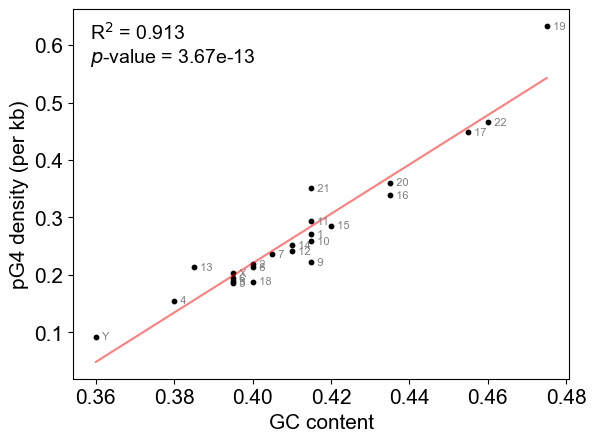

In [9]:
plt.scatter(GC_content, g4Density, color='#000', s=10)

labels = list(range(1,23)) + ['X','Y']
for i in range(len(gene_density)):
    plt.text(GC_content[i], g4Density[i], f'  {labels[i]} ', fontsize=8, ha='left', va='center', color='grey')

# fitting the model
model = LinearRegression()
model.fit(GC_content.reshape(-1,1),g4Density.dropna())
y_pred = model.predict(GC_content.reshape(-1,1))
r2 = r2_score(g4Density.dropna(), y_pred)

# plotting the fit line
plt.plot([np.min(GC_content.reshape(-1,1)), np.max(GC_content.reshape(-1,1))], [np.min(y_pred), np.max(y_pred)], color='#f00', linewidth=1.5, alpha=0.5)
plt.text(0.3585,0.61, r'R$^2$ = %.3f' %r2, fontsize=14)
plt.text(0.3585,0.57, r'$p$-value = 3.67e-13', fontsize=14)

g4Density_residuals = g4Density - y_pred

# plt.scatter(GC_content, g4Density_residuals, color='#000', s=10)
plt.tick_params(labelsize=15)
plt.xlabel("GC content",fontsize=15)
plt.ylabel("pG4 density (per kb)",fontsize=15)

plt.savefig('../plots/densityPlots/density_reg_gccontent.png',dpi=300,bbox_inches='tight')
plt.savefig('../plots/densityPlots/density_reg_gccontent.svg', format='svg', transparent=True)

# Load the data
g4denvsGC = pd.DataFrame({'g4_density': g4Density, 'gc_content': GC_content})

# Define the independent variables (constant, GCcontent, and GCcontent_squared)
X = sm.add_constant(g4denvsGC[["gc_content"]])
# X = genedenvsg4den[["GCcontent", "GCcontent_squared"]]

# Fit the quadratic model
model = sm.OLS(g4denvsGC["g4_density"], X).fit()
print(model.summary())

plt.show()

#### GC-adjusted residuals of G4 Density vs gene density

                            OLS Regression Results                            
Dep. Variable:             H. sapiens   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.124
Date:                Mon, 24 Mar 2025   Prob (F-statistic):              0.159
Time:                        17:01:05   Log-Likelihood:                 48.541
No. Observations:                  24   AIC:                            -93.08
Df Residuals:                      22   BIC:                            -90.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0168      0.013     -1.253      0.2

/var/folders/34/c98ml9js6l75mkgs9vw2bmqmcjj52k/T/ipykernel_64544/619602182.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(gene_density[i], g4Density_residuals[i], f'  {labels[i]} ', fontsize=8, ha='left', va='center', color='grey')


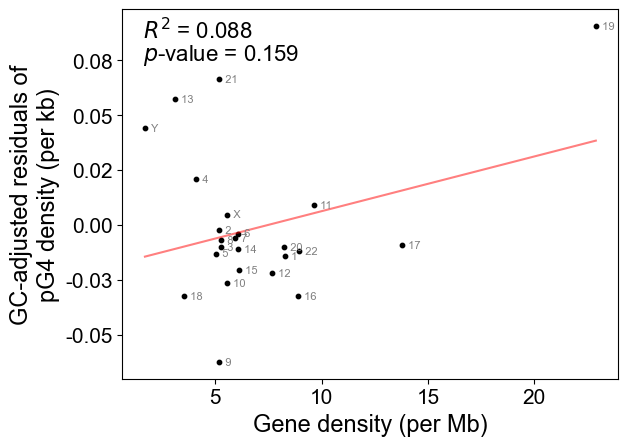

In [10]:
plt.scatter(gene_density,g4Density_residuals, color='#000', s=10)

labels = list(range(1,23)) + ['X','Y']
for i in range(len(gene_density)):
    plt.text(gene_density[i], g4Density_residuals[i], f'  {labels[i]} ', fontsize=8, ha='left', va='center', color='grey')

# fitting the model
X = sm.add_constant(gene_density)

model = sm.OLS(g4Density_residuals, X)
results = model.fit()
print(results.summary())

intercept, slope = results.params
y_pred = intercept + slope * X

# plotting the fit line
plt.plot([np.min(gene_density.reshape(-1,1)), np.max(gene_density.reshape(-1,1))], [np.min(y_pred), np.max(y_pred)], color='#f00', linewidth=1.5, alpha=0.5)
plt.text(1.6, 0.085, r'$R^2$ = %.3f' %results.rsquared, fontsize=16)
plt.text(1.6, 0.075, r'$p$-value = %.3f' %results.f_pvalue, fontsize=16)

# Define a function to format y-ticks to 2 decimal places
def format_func(value, tick_number):
    return f'{value:.2f}'

# Apply the formatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.tick_params(labelsize=15, )
plt.xlabel("Gene density (per Mb)",fontsize=17)
plt.ylabel("GC-adjusted residuals of\npG4 density (per kb)",fontsize=17)

plt.savefig('../plots/densityPlots/density_reg_g-adjust.png',dpi=300,bbox_inches='tight')
plt.savefig('../plots/densityPlots/density_reg_g-adjust.svg', format='svg', transparent=True)

plt.show()

## 3. Multivariable regression

#### Ordinary Least Squares

In [11]:
X = pd.DataFrame([gene_density, GC_content]).T
y = pd.DataFrame(g4Density)
X.index = y.index
X.columns = ['gene_density', 'GC_content']
y.columns = ['g4_density']

# Fit OLS with standardized X
X = sm.add_constant(X)  # Add intercept
ols_model_scaled = sm.OLS(y, X).fit()

# Print the summary of the regression
print(ols_model_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:             g4_density   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     164.3
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           1.50e-13
Time:                        17:01:06   Log-Likelihood:                 51.843
No. Observations:                  24   AIC:                            -97.69
Df Residuals:                      21   BIC:                            -94.15
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.0791      0.169     -6.375   

#### Ridge Regression

In [12]:
X = pd.DataFrame([gene_density, GC_content]).T
y = pd.DataFrame(g4Density)
X.index = y.index
X.columns = ['gene_density', 'GC_content']
y.columns = ['g4_density']

# X = pd.DataFrame(X['gene_density'])

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

ridge = Ridge(alpha=0.00125)#0.00125)  # Adjust alpha as needed

# Fit the model
ridge.fit(X, y)

# Print coefficients
print("Ridge Coefficients:", ridge.coef_)
print("Intercept:", ridge.intercept_)
print("R^2:", ridge.score(X, y))

Ridge Coefficients: [[0.01200336 2.44399247]]
Intercept: [-0.81858221]
R^2: 0.9331115155457301


#### Ridge Regression Cross Validation

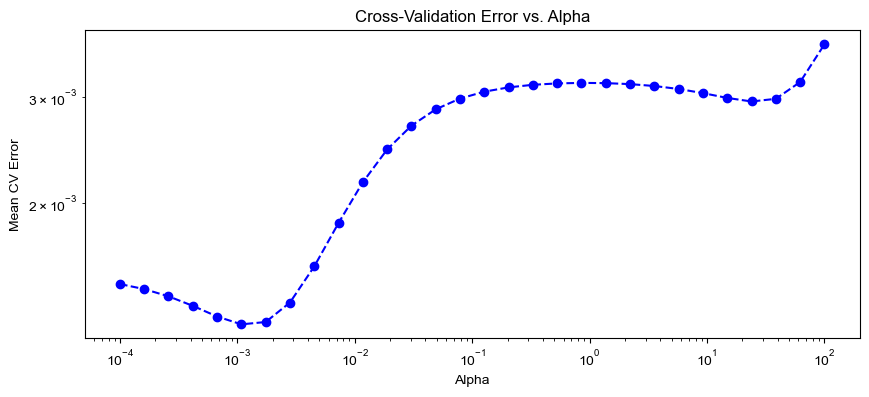

In [13]:
## cross-validation
 
alphas = np.linspace(0.000001, 30, 50)
alphas = np.logspace(-4, 2, 30)

ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)  # store_cv_values=True saves cross-validation errors
ridge_cv.fit(X, y)

# Get mean squared errors for each alpha (stored in ridge_cv.cv_values_)
cv_errors = ridge_cv.cv_values_.mean(axis=0)

#remove a dimension from cv_errors
cv_errors = cv_errors.squeeze()
plt.figure(figsize=(10, 4))
plt.loglog(alphas, cv_errors, marker='o', linestyle='--', color='b')  # Log scale for better visualization
plt.xlabel("Alpha")
plt.ylabel("Mean CV Error")
plt.title("Cross-Validation Error vs. Alpha")

plt.savefig('../plots/densityPlots/ridge_cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()